**Import necessary libraries**

In [1]:
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.models import vit_b_16, VisionTransformer
from torchvision.models.feature_extraction import create_feature_extractor

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Data Loading and Preprocessing**

In [3]:
# Define transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

In [4]:
# Load the dataset from the root directory
dataset = datasets.ImageFolder(root='dataset', transform=data_transform)

# Splitting the dataset
train_size = int(0.7 * len(dataset)) 
val_size = int(0.15 * len(dataset)) 
test_size = len(dataset) - train_size - val_size 

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

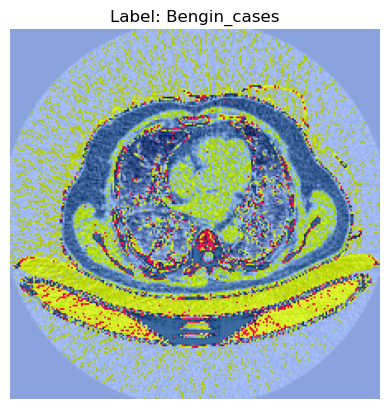

In [5]:
# Access an image and its label
img_tensor, label = dataset[0]  

# To visualize the image, convert the tensor back to a PIL image
img = transforms.ToPILImage()(img_tensor)

# Display the image using PIL
img.show()

plt.imshow(img)
# Display the label of the image
plt.title(f'Label: {dataset.classes[label]}')  
plt.axis('off') 
plt.show()

**Define the Model**

In [46]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)  
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.25)  
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(in_features=128 * 28 * 28, out_features=512)
        self.fc2 = nn.Linear(512, 3)
        self.dropout4 = nn.Dropout(0.5)


    def forward(self, x):
        x = self.pool(self.bn1(self.act1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(self.bn2(self.act2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(self.bn3(self.act3(self.conv3(x))))
        x = self.dropout3(x)
        x = torch.flatten(x, 1)
        x = self.dropout4(self.fc1(x))
        x = self.fc2(x)

        return x


**Initialize Model, Loss Function, and Optimizer**

In [47]:
model = SimpleCNN()
model.to(device)  

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU()
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
)

**Train and evaluate the model**

In [48]:
# Initialize lists to store accuracies and losses
train_accuracies = []
test_accuracies = []
validation_accuracies = []

train_losses = []
validation_losses = []

In [49]:
def train_and_evaluate(model, train_loader, validation_loader, test_loader, epochs=10):
    # Define your device at the beginning of your function
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move your model to the selected device
    model.to(device)
    
    # Initialize or reinitialize your optimizer here, after moving the model to the device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss / len(train_loader))

        # Validation phase
        model.eval()
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct_validation / total_validation
        validation_accuracies.append(validation_accuracy)
        validation_losses.append(validation_loss / len(validation_loader))

        # Evaluate on the test set
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Validation Loss: {validation_loss/len(validation_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Accuracy: {validation_accuracy:.2f}%, "
              f"Test Accuracy: {test_accuracy:.2f}%")

In [51]:
train_and_evaluate(model, train_loader, validation_loader, test_loader, epochs=10)

OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 10.50 GiB is allocated by PyTorch, and 191.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

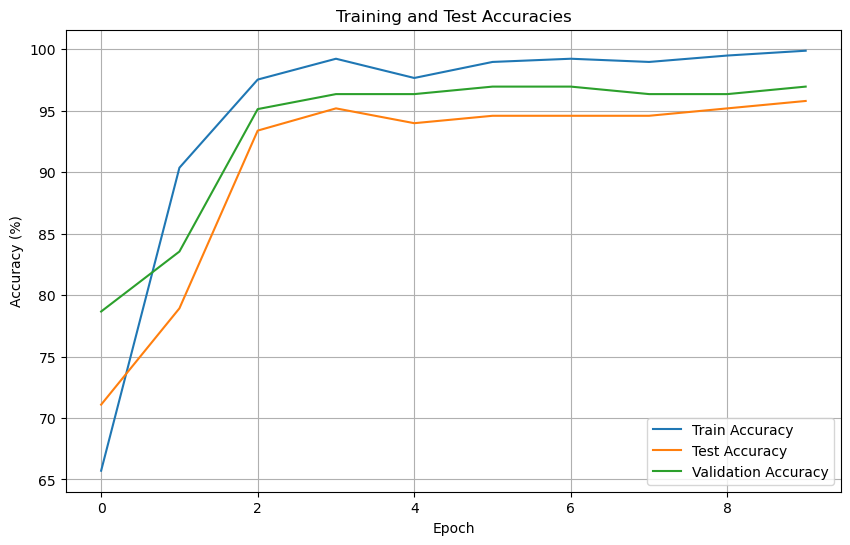

In [11]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracies')
plt.legend()
plt.grid(True)
plt.show()

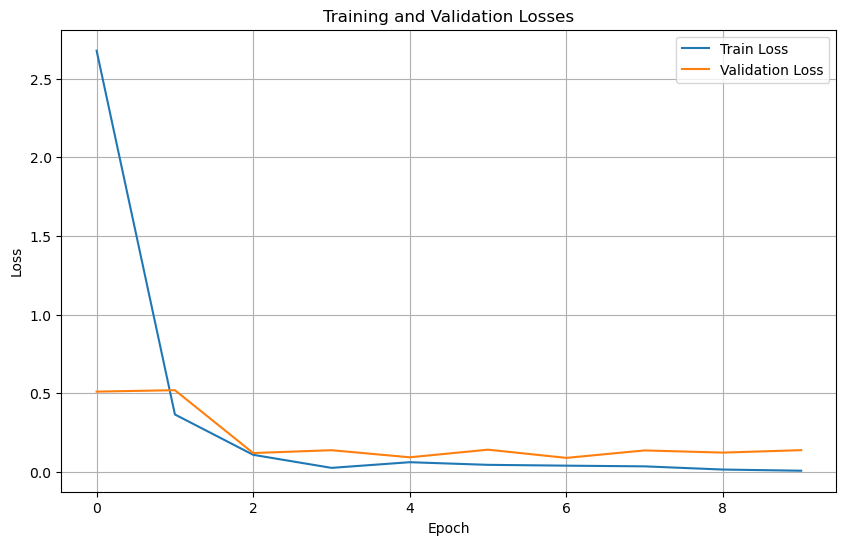

In [12]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

**Second model trial**

In [36]:
class CNNViT(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNViT, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.vit = vit_b_16(pretrained=True)
        
        in_features = self.vit.heads[0].in_features
        self.vit.heads[0] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        torch.unsqueeze(x,0)
        
        # Assuming your CNN output is [B, C, H, W]
        # And you've determined the correct size `N` for the sequence length expected by your ViT
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)  # Rearrange to [B, H, W, C]
        x = x.view(B, H * W, C)  # Flatten H, W dimensions and keep the channel dimension
        
        # Ensure this matches the ViT's patch size and sequence length expectations
        # You might need additional adjustments here based on your specific ViT configuration
        
        x = self.vit(x)
        
        return x

In [37]:
model2 = CNNViT(3)
model2.to(device)  

d:\Users\ZJY\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Users\ZJY\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNNViT(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_feat

In [38]:
# Initialize lists to store accuracies and losses
train_accuracies = []
test_accuracies = []
validation_accuracies = []

train_losses = []
validation_losses = []

In [39]:
train_and_evaluate(model2, train_loader, validation_loader, test_loader, epochs=10)

ValueError: not enough values to unpack (expected 4, got 3)